In [117]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

In [118]:
pickle_file = 'data/DATA_DECEASED.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)

In [119]:
numeric_features = [
    "AGE",
    "BMI_CALC",
    "AGE_DON",
    "CREAT_TRR",
    "NPKID",
    "RDR2",
    "DR53",
    "DR2",
    "COLD_ISCH_KI",
    "CREAT_DON",
]
categorical_features = [
    "ON_DIALYSIS",
    "PRE_TX_TXFUS",
    "GENDER",
    "ETHCAT",
    "DIABETES_DON",
    "DIAB",
    "HCV_SEROSTATUS",
]


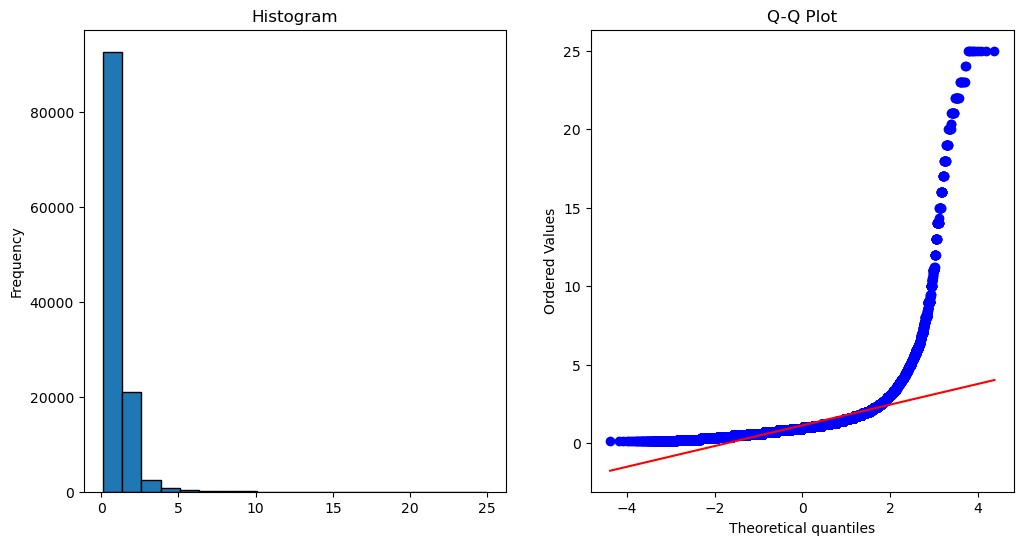

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import probplot

# Assuming 'df' is your DataFrame and 'column_name' is the column you want to check
data = dataset['CREAT_DON']

# Histogram
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
data.plot(kind='hist', bins=20, edgecolor='black')
plt.title('Histogram')

# Q-Q plot
plt.subplot(1, 2, 2)
probplot(data, dist='norm', plot=plt)
plt.title('Q-Q Plot')

plt.show()


In [121]:
from scipy.stats import shapiro

# Shapiro-Wilk test
stat, p_value = shapiro(data)

print(f'Statistic: {stat}, p-value: {p_value}')

Statistic: 0.48773443698883057, p-value: 0.0


/Users/kyrylo/anaconda3/envs/kidney-life/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [122]:
numeric_columns = dataset.select_dtypes(include=np.number).columns
numeric_stats = {}

for column in numeric_columns:
    column_stats = {
        "IQR": dataset[column].quantile(0.75) - dataset[column].quantile(0.25),
        "median": dataset[column].median()
    }
    numeric_stats[column] = column_stats

numeric_stats


{'DR53': {'IQR': 96.0, 'median': 0.0},
 'NPKID': {'IQR': 0.0, 'median': 0.0},
 'COLD_ISCH_KI': {'IQR': 11.13, 'median': 17.0},
 'BMI_CALC': {'IQR': 7.5, 'median': 27.3},
 'AGE_DON': {'IQR': 27.0, 'median': 40.0},
 'DR2': {'IQR': 8.0, 'median': 13.0},
 'CREAT_TRR': {'IQR': 4.6000000000000005, 'median': 7.82},
 'AGE': {'IQR': 19.0, 'median': 53.0},
 'RDR2': {'IQR': 5.0, 'median': 13.0},
 'CREAT_DON': {'IQR': 0.6000000000000001, 'median': 0.96}}

In [123]:
def generate_synthetic_numeric_data(column):
    synthetic_data = np.random.normal(loc=numeric_stats[column]["median"], scale=numeric_stats[column]["IQR"], size=1)
    synthetic_data = np.clip(synthetic_data, 0, None)
    synthetic_data = np.round(synthetic_data)
    print(column, synthetic_data)

    return synthetic_data

In [124]:
for column in numeric_columns:
    generate_synthetic_numeric_data(column)

DR53 [0.]
NPKID [0.]
COLD_ISCH_KI [13.]
BMI_CALC [22.]
AGE_DON [42.]
DR2 [23.]
CREAT_TRR [8.]
AGE [72.]
RDR2 [11.]
CREAT_DON [0.]


In [125]:
categorical_freq_dict = {}

for feature in categorical_features:
    freq_dict = {}
    categories = dataset[feature].value_counts(normalize=True).to_dict()
    total_samples = len(dataset)
    
    for category, count in categories.items():
        freq_dict[category] = round(count, 2)
    
    categorical_freq_dict[feature] = freq_dict

categorical_freq_dict #, categories_dict


{'ON_DIALYSIS': {'Y': 0.78, 'N': 0.22},
 'PRE_TX_TXFUS': {'N': 0.75, 'Y': 0.25},
 'GENDER': {'M': 0.6, 'F': 0.4},
 'ETHCAT': {'1': 0.47, '2': 0.31, '4': 0.15, '5': 0.06, '6': 0.01, '7': 0.0},
 'DIABETES_DON': {'N': 0.93, 'Y': 0.07},
 'DIAB': {'1.0': 0.66,
  '3.0': 0.19,
  '5.0': 0.11,
  '2.0': 0.03,
  '998.0': 0.01,
  '4.0': 0.0},
 'HCV_SEROSTATUS': {'N': 0.9, 'P': 0.06, 'ND': 0.04}}

In [126]:
def generate_synthetic_categorical_data(feature):
    freq_dict = categorical_freq_dict[feature]
    categories = list(freq_dict.keys())
    probabilities = list(freq_dict.values())
    
    synthetic_data = np.random.choice(categories, size=1, p=probabilities)[0]
    print(feature, synthetic_data)
    
    return synthetic_data


In [127]:
for column in categorical_features:
    generate_synthetic_categorical_data(column)

ON_DIALYSIS Y
PRE_TX_TXFUS N
GENDER F
ETHCAT 1
DIABETES_DON Y
DIAB 1.0
HCV_SEROSTATUS N


# Living coxnet

In [128]:
yes_categorical=["PRE_TX_TXFUS", 
                "GENDER",
                "ON_DIALYSIS", 
                "ABO_MAT", 
                "ETHCAT", 
                "ETHCAT_DON",
                'HBV_CORE', 
                'DIAB',
                'HBV_SUR_ANTIGEN', 
                'HCV_SEROSTATUS',  
                'LIV_DON_TY',
            ]
yes_numerical = [   
                "KI_CREAT_PREOP",
                "SERUM_CREAT",
                'BMIS', 
                "NPKID", 
                "AGE", 
                "HGT_CM_CALC", 
                "BMI_DON_CALC",
                "AGE_DON", 
                'DR1', 
                'BW6', 
                'BW4', 
                'RA1',
                'A2', 
                'DR53', 
                'C1', 
                'C2', 
                'A1',
                'RA2', 
                'DR51',
                'DR52', 
                'DQ2', 
                'RDR1',
                ]

In [129]:
pickle_file = 'data/COX_DATA_FULL_LIVING.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)

dataset.drop(['DIAG_KI', 'COD_KI'], axis=1, inplace=True)

In [130]:
categorical_freq_dict = {}

for feature in yes_categorical:
    freq_dict = {}
    categories = dataset[feature].value_counts(normalize=True).to_dict()
    total_samples = len(dataset)

    # Calculate unrounded probabilities
    unrounded_probabilities = list(categories.values())

    # Round the probabilities to a fixed number of decimal places
    rounded_probabilities = [round(prob, 2) for prob in unrounded_probabilities]

    # Adjust one probability to ensure the sum is exactly 1
    rounding_difference = 1 - sum(rounded_probabilities)
    if rounding_difference != 0:
        max_prob_index = rounded_probabilities.index(max(rounded_probabilities))
        rounded_probabilities[max_prob_index] += rounding_difference

    for category, prob in zip(categories.keys(), rounded_probabilities):
        freq_dict[category] = prob

    categorical_freq_dict[feature] = freq_dict

categorical_freq_dict


{'PRE_TX_TXFUS': {'N': 0.83, 'Y': 0.17},
 'GENDER': {'M': 0.61, 'F': 0.39},
 'ON_DIALYSIS': {'Y': 0.55, 'N': 0.45},
 'ABO_MAT': {'1.0': 0.75, '2.0': 0.23, '3.0': 0.02},
 'ETHCAT': {'1': 0.65,
  '4': 0.15,
  '2': 0.14,
  '5': 0.05,
  '6': 0.01,
  '9': 0.0,
  '7': 0.0},
 'ETHCAT_DON': {'1.0': 0.7,
  '4.0': 0.14,
  '2.0': 0.12,
  '5.0': 0.04,
  '9.0': 0.0,
  '6.0': 0.0,
  '7.0': 0.0},
 'HBV_CORE': {'N': 0.82, 'ND': 0.13, 'P': 0.05},
 'DIAB': {'1.0': 0.72,
  '3.0': 0.19,
  '2.0': 0.06,
  '5.0': 0.02,
  '998.0': 0.01,
  '4.0': 0.0},
 'HBV_SUR_ANTIGEN': {'N': 0.97, 'P': 0.02, 'ND': 0.01},
 'HCV_SEROSTATUS': {'N': 0.97, 'P': 0.02, 'ND': 0.01},
 'LIV_DON_TY': {'999.0': 0.21999999999999978,
  '4.0': 0.22,
  '2.0': 0.17,
  '7.0': 0.12,
  '6.0': 0.07,
  '9.0': 0.07,
  '1.0': 0.06,
  '10.0': 0.03,
  '11.0': 0.02,
  '5.0': 0.01,
  '8.0': 0.01,
  '3.0': 0.0,
  '12.0': 0.0}}

In [131]:
for feature in yes_categorical:
    generate_synthetic_categorical_data(feature)

PRE_TX_TXFUS Y
GENDER F
ON_DIALYSIS N
ABO_MAT 1.0
ETHCAT 1
ETHCAT_DON 2.0
HBV_CORE N
DIAB 1.0
HBV_SUR_ANTIGEN N
HCV_SEROSTATUS N
LIV_DON_TY 999.0


In [132]:
# numeric_columns = dataset.select_dtypes(include=np.number).columns
dataset[yes_numerical] = dataset[yes_numerical].astype(float)
numeric_stats = {}

for column in yes_numerical:
    column_stats = {
        "IQR": round(dataset[column].quantile(0.75) - dataset[column].quantile(0.25), 2),
        "median": round(dataset[column].median(), 2)
    }
    numeric_stats[column] = column_stats

numeric_stats


{'KI_CREAT_PREOP': {'IQR': 0.3, 'median': 0.8},
 'SERUM_CREAT': {'IQR': 0.82, 'median': 1.4},
 'BMIS': {'IQR': 1.0, 'median': 1.0},
 'NPKID': {'IQR': 0.0, 'median': 0.0},
 'AGE': {'IQR': 21.0, 'median': 49.0},
 'HGT_CM_CALC': {'IQR': 15.4, 'median': 171.0},
 'BMI_DON_CALC': {'IQR': 5.97, 'median': 26.63},
 'AGE_DON': {'IQR': 19.0, 'median': 42.0},
 'DR1': {'IQR': 9.0, 'median': 7.0},
 'BW6': {'IQR': 0.0, 'median': 95.0},
 'BW4': {'IQR': 1.0, 'median': 95.0},
 'RA1': {'IQR': 9.0, 'median': 2.0},
 'A2': {'IQR': 28.0, 'median': 24.0},
 'DR53': {'IQR': 96.0, 'median': 95.0},
 'C1': {'IQR': 6.0, 'median': 2.0},
 'C2': {'IQR': 7.0, 'median': 0.0},
 'A1': {'IQR': 9.0, 'median': 2.0},
 'RA2': {'IQR': 43.0, 'median': 29.0},
 'DR51': {'IQR': 96.0, 'median': 95.0},
 'DR52': {'IQR': 95.0, 'median': 95.0},
 'DQ2': {'IQR': 7.0, 'median': 4.0},
 'RDR1': {'IQR': 9.0, 'median': 7.0}}